In [2]:
!pip install azure-storage-blob

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 407.0/407.0 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 14.4 MB/s eta 0:00:00


In [12]:
from azure.storage.blob import BlobServiceClient
from io import StringIO
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer


In [4]:
#connection string
connection_string = "DefaultEndpointsProtocol=https;AccountName=mahashree;AccountKey=z38G+WDQzDCRfUIXxbBfxWons2vciJBpn9UAFxwffM4D3lwrUQHfy0ENM1guN1/ZhwLlXHDKsF7B+AStXCEcEw==;EndpointSuffix=core.windows.net"
blob_service_client = BlobServiceClient.from_connection_string(connection_string)

#container and file names
container_name = "datasets"
blob_name = "Diabetes Classification.csv"

#blob client and read CSV
blob_client = blob_service_client.get_blob_client(container= "datasets", blob="Diabetes Classification.csv")
blob_data = blob_client.download_blob().content_as_text()

# Load into a DataFrame
df = pd.read_csv(StringIO(blob_data))
df.head()


,Unnamed: 0,Age,Gender,BMI,Chol,TG,HDL,LDL,Cr,BUN,Diagnosis
0,0,50,F,24,4.2,0.9,2.4,1.4,46.0,4.7,0
1,1,26,M,23,3.7,1.4,1.1,2.1,62.0,4.5,0
2,2,33,M,21,4.9,1.0,0.8,2.0,46.0,7.1,0
3,3,45,F,21,2.9,1.0,1.0,1.5,24.0,2.3,0
4,4,50,F,24,3.6,1.3,0.9,2.1,50.0,2.0,0


In [5]:
# Drop index column if exists
df.drop(columns=['Unnamed: 0'], inplace=True)

# Encode Gender column
df['Gender'] = df['Gender'].map({'F': 0, 'M': 1})

# Define Features and Target
X = df.drop('Diagnosis', axis=1)
y = df['Diagnosis']


In [17]:
# 1. Train-test split
from sklearn.model_selection import train_test_split
X = df.drop("Diagnosis", axis=1)
y = df["Diagnosis"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Handle missing values using Imputer BEFORE scaling
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')

X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# 3. Scale the imputed data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# 4. Train Logistic Regression model
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train_scaled, y_train)


LogisticRegression()

In [18]:
#model evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred = model.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))



Accuracy: 0.8023369036027264
Confusion Matrix:
 [[529  75]
 [128 295]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.88      0.84       604
           1       0.80      0.70      0.74       423

    accuracy                           0.80      1027
   macro avg       0.80      0.79      0.79      1027
weighted avg       0.80      0.80      0.80      1027



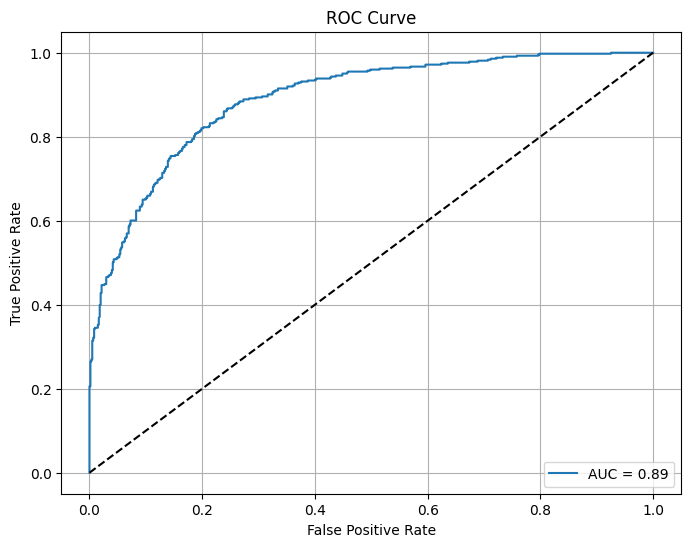

In [19]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_prob = model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [20]:
import joblib

joblib.dump(model, "diabetes_model.pkl")


['diabetes_model.pkl']

In [21]:
import pickle

# Assume your trained model is named 'model'
with open("diabetes_model.pkl", "wb") as f:
    pickle.dump(model, f)


In [22]:
from google.colab import files
files.download("diabetes_model.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>